In [ ]:
# |default_exp declerative

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide

from stringdale.core import checkLogs
import pytest

In [ ]:
#| export
from copy import deepcopy,copy
import itertools
import logging
import asyncio

from collections import defaultdict,OrderedDict
from contextlib import ExitStack
from pprint import pprint
from pydantic import BaseModel
from singleton_decorator import singleton

from typing import Optional,Union,List,Dict,Any,Literal,Callable
from fastcore.basics import patch
import logging

from stringdale.core import wrap_exception, NamedLambda
from stringdale.mappings import parse_edge_descriptor
from stringdale.base import (
    DiagramSchema,Diagram,BaseModelExtra,DiagramType
    ,_is_attr_method,get_state_key,set_state_key)

In [ ]:
#| export
logger = logging.getLogger(__name__)

In [ ]:
#| export
from IPython.display import display,Image,Markdown


## Track Current define

In [ ]:
#| export

@singleton
class CurrentScheme():
    def __init__(self):
        self.current_diagram = None
        self.current_scope = []

    def set(self,scheme:DiagramSchema):
        if self.current_diagram is not None:
            raise ValueError("Cannot Define a stringdale diagram inside another stringdale diagram")
        self.current_diagram = scheme

    def clear(self):
        self.current_diagram = None
        self.current_scope = []

    def get(self):
        if self.current_diagram is None:
            raise ValueError("No current diagram set, make sure you are inside a Define() scope")
        return self.current_diagram

    def is_curr_decision(self):  
        return self.current_scope[-1] == DiagramType.decision

    def is_curr_flow(self):
        return self.current_scope[-1] == DiagramType.flow

    def start_scope(self,scope):
        if isinstance(scope, str):
            try:
                scope = DiagramType(scope)
            except ValueError:
                raise ValueError(f"Scope {scope} not supported, only {DiagramType.decision} and {DiagramType.flow} ")
        self.current_scope.append(scope)

    def end_scope(self):
        self.current_scope.pop()




## Define

In [ ]:
#| export
from contextlib import contextmanager

@contextmanager 
def Define(diagram_name, type:str='flow',
    state:BaseModel=BaseModelExtra,
    validate:bool=True,):
    """Define a new diagram using a context manager.
    
    Args:
        diagram_name: Name for the new diagram
        type: The type of diagram to create, either 'flow' or 'decision'. Defaults to 'flow'
        state: The state class to use for the diagram. Defaults to BaseModelExtra
        validate: If True, validates diagram structure after definition. Defaults to True
        
    Yields:
        The created diagram object
        
    Raises:
        ValueError: If diagram_name already exists and solve_name_conflicts is False
    """
    curr = CurrentScheme()

   
    schema = DiagramSchema(name=diagram_name,state_class=state)
    curr.set(schema)
    
    curr.start_scope(type)

    try:
        yield schema
        if validate:
            logger.debug('Validating diagram structure')
            try:
                schema.post_def()
            except Exception as e:
                schema.draw()
                raise e
    except Exception as e:
        schema.draw()
        raise e

    finally:
        curr.clear()

## Scope

In [ ]:
#| export
@contextmanager 
def Scope(scope:str):
    """Context manager for defining a flow/decision scope in a diagram of a different type

    Args:
        scope: The scope type to start. Can be either a string ('flow' or 'decision').
    """
    if isinstance(scope,str):
        scope = DiagramType(scope)
    curr = CurrentScheme()
    curr.start_scope(scope)
    try:
        yield
    finally:
        curr.end_scope()


## E

In [ ]:
#| export

@wrap_exception("When adding edge {{edge_string}} with condition {{cond}}, type {{type}} and edge_data {{edge_data}}")
def _add_edge(edge_string,edge_data,cond=None,type:Optional[DiagramType]=None):
    """Add an edge to the current diagram
    
    Args:
        edge_string: The edge descriptor string
        edge_data: The edge data dictionary parsed from the edge descriptor string
        cond: The condition of the edge
        type: The type of the edge
    """
    
    # logger.debug(f"TAdding edge from {edge_string} with condition {cond} and type {type}")
    curr = CurrentScheme()
    curr_diagram = curr.get()
    g = curr_diagram.graph
    if type is not None:
        allowed_types = [t.name for t in DiagramType]
        if type not in allowed_types:
            raise ValueError(f"Invalid edge type: {type}, must be one of: {allowed_types}")
        type = DiagramType[type]
        is_flow = type == DiagramType.flow
    else:
        is_flow = curr.is_curr_flow()
    
    if is_flow and cond is not None:
        raise ValueError(f"Cannot have condition in flow scope, edge: {edge_string}")


    source_node = edge_data.pop('source_node')
    target_node = edge_data.pop('target_node')
    mapping = edge_data['mapping']

    if (source_node,target_node) in g.edges:
        raise ValueError(f"Edge {source_node}->{target_node} already exists, edge: {edge_string}\n")


    edge_type = edge_data['edge_type']

    # add nodes if they are not state and not already in the diagram
    # allows referencing nodes ahead of definition
    if edge_type != 'read_edge' and not source_node in curr_diagram.graph.nodes:
        curr_diagram.graph.add_node(source_node)

    if edge_type != 'write_edge' and not target_node in curr_diagram.graph.nodes:
        curr_diagram.graph.add_node(target_node)

    match edge_type:
        case 'edge':
            type = DiagramType.flow if is_flow else DiagramType.decision
            edge_attrs = {'type':type,'mapping':mapping}
            if cond is not None:
                edge_attrs['condition'] = cond
            logger.debug(f"Adding edge from {source_node} to {target_node} with data {edge_attrs}")
            g.add_edge(source_node,target_node,**edge_attrs)
            
        case 'read_edge':
            key = source_node
            read_state = g.nodes[target_node].get('read_state',dict())
            read_state[key] = mapping
            g.nodes[target_node]['read_state'] = read_state
        case 'write_edge':
            key = target_node
            write_state = g.nodes[source_node].get('write_state',dict())
            write_state[key] = mapping
            g.nodes[source_node]['write_state'] = write_state
        case _:
            raise ValueError(f"Invalid edge type: {edge_type}")

    return

def E(edge_string:str,cond:Callable=None,type:str=None)->None:
    """Add an edge to the current diagram
    
    Args:
        edge_string: The edge descriptor string
        cond: The condition of the edge
        type: The type of the edge, either 'flow' or 'decision', by default, the type is determined by the current scope    
    """
    edge_data = parse_edge_descriptor(edge_string,start='edge')
    _add_edge(edge_string,edge_data,cond,type)


## V

In [ ]:
#| export 

@wrap_exception("When adding node {{name}}")
def V(name:str, 
        func:Callable=None,
        inputs:Any=None,outputs=None,
        is_break:bool=False,
        for_each:Optional[List[str]]=None,
        filter:bool=False,
        flat:bool=False,
        as_start:bool=False,
        as_end:bool=False,
        )->None:
    """Add a vertex (node) to the current diagram.
    
    Args:
        name (str): Name of the node
        func (callable, optional): Function to execute at this node. If None, node acts as a passthrough
        inputs (List[str], optional): List of input edge descriptors. Each descriptor can be either:
            - A string in format "source_node.source_port->target_port" 
            - A tuple (edge_descriptor, condition_func) for conditional edges
        outputs (List[str], optional): List of output edge descriptors. Each descriptor can be either:
            - A string in format "source_port->target_node.target_port"
            - A tuple (edge_descriptor, condition_func) for conditional edges
        is_break (bool, optional): If True, execution will pause at this node. Not allowed in flow scopes
        for_each (List[str|int], optional): List of input keys to iterate over. 
            Used for batching operations in Flow diagrams.
            If provided, the node will be executed once for each product of items in the input list.
            This for each keys must get iteratbles from the input edges.
        filter (bool, optional): Used for batching operations in Flow diagrams. 
            If True, falsy node outputs will be filtered out. 
            Cannot be used with flat=True
        flat (bool, optional): Used for batching operations in Flow diagrams.
            If True, node output lists will be flattened into a single list.
            Cannot be used with filter=True
        as_start (bool, optional): If True, marks this node as the diagram's start node
        as_end (bool, optional): If True, marks this node as the diagram's end node
    
    Returns:
        str: Name of the created node

    
    Raises:
        ValueError: If both filter and flat are True
        ValueError: If validator is not callable or BaseModel
        ValueError: If break node is used in flow scope
    """
    
    if not func is None and not callable(func):
        raise ValueError("func must be a callable or None, not {func}")
    
    # get current diagram
    curr = CurrentScheme()

    curr_diagram = curr.get()
    is_flow = curr.is_curr_flow()

    if is_flow and is_break:
        raise ValueError("Break nodes are not allowed in flow scopes")

    
    node_data = dict()
    
    if is_break:
        node_data['is_break'] = True

    if not is_flow and any(x for x in [filter,flat,for_each]):
        raise ValueError("Cannot have batching operations in non-flow diagrams")

    if filter and flat:
        raise ValueError("Cannot have both filter and flat attributes")
    if for_each is not None:
        if not hasattr(for_each, '__iter__'):
            raise ValueError(f"for_each must be iterable, got: {for_each}")
        if not all(isinstance(item, (str,int)) for item in for_each):
            raise ValueError(f"for_each must be a list of strings or integers, got: {for_each}")
        node_data['for_each'] = for_each
    if filter:
        node_data['filter'] = True
    if flat:
        node_data['flat'] = True
    
    # TODO enable node level data validation
    # for validator in [input_validator,output_validator]:
    #     if validator is not None:
    #         if not callable(validator) or not isinstance(validator,BaseModel):
    #             raise ValueError(f"Validator {validator} can only be a callable function or a BaseModel")

    # if input_validator is not None:
    #     node_data['input_validator'] = input_validator
    # if output_validator is not None:
    #     node_data['output_validator'] = output_validator

    
    if func is not None:
        node_data['func'] = func

    if inputs is None:
        inputs = []
    if outputs is None:
        outputs = []
    
    def _parse_implicit_edge_with_condition(desc):
    
        if isinstance(desc,tuple) and len(desc) == 2 and isinstance(desc[0],str) and callable(desc[1]):
            edge_string,cond = desc
            return edge_string,cond
        elif isinstance(desc,str):
            edge_string = desc
            return edge_string,None
        else:
            raise ValueError(f"Invalid edge descriptor, must be either (edge_string,cond) or edge_string, not: {desc}")
    
    logger.debug(f"Adding node {name} to diagram {curr_diagram} with attributes {node_data}")
    # try to get previous node data if was defined by edge
    curr_diagram.graph.add_node(name,**node_data)
    
    for implicit_edge in inputs + outputs:
        edge_string,cond = _parse_implicit_edge_with_condition(implicit_edge)
        edge_data = parse_edge_descriptor(edge_string,start='implicit_edge')
        if edge_data['edge_type'] == 'implicit_edge':
            edge_data['edge_type'] = 'edge'
        elif edge_data['edge_type'] == 'implicit_state_edge':
            if implicit_edge in inputs:
                edge_data['edge_type'] = 'read_edge'
            else:
                edge_data['edge_type'] = 'write_edge'

        if implicit_edge in inputs:
            edge_data['target_node'] = name
            edge_data['source_node'] = edge_data.pop('node')
            logger.debug(f"Adding read state edge from key {edge_data['source_node']} to node {edge_data['target_node']} with mapping {edge_data['mapping']}")
        else:
            edge_data['source_node'] = name
            edge_data['target_node'] = edge_data.pop('node')
            logger.debug(f"Adding write state edge from node {edge_data['source_node']} to key {edge_data['target_node']} with mapping {edge_data['mapping']}")
        _add_edge(edge_string,edge_data,cond=cond)


    if as_start:
        curr_diagram.start_node = name
    if as_end:
        curr_diagram.end_node = name

    return name




## Test

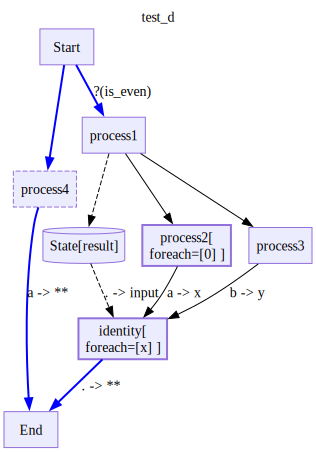

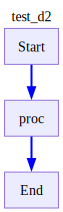

In [ ]:
with checkLogs(name='__main__'):
    with Define('test_d',type='decision',validate=False) as TestD:
        V('process4',is_break=True)
        E('Start->process4')
        E('process4->End(**=a)')
        E('Start->process1',NamedLambda('is_even',lambda x: x%2==0))
        E('identity->End(**)')

        with Scope('flow'):
            V('process1',
                func=NamedLambda('add1',lambda x: x+1),
                outputs=['state/result'],)
            V('process2',
                func=NamedLambda('add2',lambda x: x+2),
                inputs=['process1'],
                for_each =[0]
                )
            V('process3',
                func=NamedLambda('add5',lambda x: x+5),
                inputs=['process1'],)
            V('identity',
                inputs=['process2(x=a)',
                        'process3(y=b)',
                        'state/result(input=.)',
                        ],
                for_each = ['x']
                        )


with Define('test_d2',type='decision',validate=False) as TestD2:
    V('proc',TestD,
        inputs=['Start'],
        outputs=['End'],
    )


TestD.draw()
TestD2.draw()

## Export

In [ ]:
# |hide
import nbdev

nbdev.nbdev_export()